# Imports 

In [1]:
import ROOT as rt
import csv
import re
import sys
import collections
from collections import OrderedDict
import uproot
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
from numpy import linalg as LA
from ROOT import TLorentzVector
from array import array
# import PyTEX
import os

import math
import random
from optparse import OptionParser

sys.path.append('/storage/user/jmao/gpu/jmao/cms-llp/delayed_jet_analyzer/lib/')

from histo_utilities import create_TH1D, create_TH2D, create_TGraph,std_color_list, make_ratio_plot

import CMS_lumi, tdrstyle 
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Simulation Preliminary"

     
print(sys.version)

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
import pandas as pd
import pickle as pickle
import shlex
import uproot
import seaborn as sns

from scipy.spatial.distance import cdist
from collections import Counter 
import datetime
import pytz

from prettytable import PrettyTable
from pyjet import cluster

import xgboost as xgb
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier


Welcome to JupyROOT 6.18/02
3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


In [2]:
# root settings
rt.gROOT.SetBatch(True)
rt.gStyle.SetOptStat(0)
rt.gStyle.SetOptFit(111)
rt.gStyle.SetPaintTextFormat("2.1f")

# plt.rcParams["font.family"] = "Arial"
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams["text.usetex"] = False
plt.rcParams["mathtext.fontset"] = "cm"

# test_name = 'xgb_HH_vs_QCD_ebBDT'

lumi_sf_sig = 137.0 # scale lumi from sample to full run2
lumi_sf_bkg = 137.0

#output dir
 
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200612/'
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200728/2018/'
plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200814/DataCards/v0/'

os.system("mkdir -p "+ plotDir)

0

# Loading

In [7]:
data_home_dir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200804/'
sig_home_dir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200814/'
SignalInput = 'CTAUSignalSummaryTableBin2Rebin.txt'
OLDSignalInput = 'SignalSummaryTableBin2Rebin.txt' 
DataInput = 'PredictionSummaryTableBin2Rebin.txt'

In [9]:

years = []
years = [
            '2016',
            '2017',
            '2018',
]

data_bin2 = {}
data_bin2err = {}

data_f=open(data_home_dir+DataInput, 'r')
for data_l in data_f:
    
    if 'Data' in data_l:
        data_ws = data_l.split('|')
        
 
        
        year = data_ws[1].split(' ')[2]
        bin2 = float(data_ws[3].lstrip(' ').rstrip(' '))
        bin2err = float(data_ws[4].lstrip(' ').rstrip(' '))
        
 
        
        data_bin2[year] = bin2
        data_bin2err[year] = bin2err
        
data_f.close()



In [10]:
data_f=open(data_home_dir+DataInput, 'r')
print(data_f.read())
data_f.close()

data_bin2_sum = 0
data_bin2_sum_err_tmp = 0
for year in years:
    print(year, data_bin2[year], data_bin2err[year])
    data_bin2_sum += data_bin2[year]
    data_bin2_sum_err_tmp += pow(data_bin2err[year],2)

data_bin2_sum_err = round(math.sqrt(data_bin2_sum_err_tmp),2)

print('Data sum',data_bin2_sum)
print('Data sum err',data_bin2_sum_err)


+-----------+--------+------------------+------------------------+---------------------------+----------------------------+
|   Sample  | method | Bin 2 Prediction | Bin 2 Prediction Error | Bin 2 Prediction Error Up | Bin 2 Prediction Error Low |
+-----------+--------+------------------+------------------------+---------------------------+----------------------------+
| Data 2018 | 1D pt  |       0.58       |          0.26          |            0.35           |            0.18            |
| Data 2017 | 1D pt  |       0.88       |          0.45          |            0.61           |            0.29            |
| Data 2016 | 1D pt  |       1.47       |          0.58          |            0.74           |            0.41            |
+-----------+--------+------------------+------------------------+---------------------------+----------------------------+
2016 1.47 0.58
2017 0.88 0.45
2018 0.58 0.26
Data sum 2.93
Data sum err 0.78


In [11]:
# ctaus=np.array([10, 30, 40, 50, 60, 80, 100, 200, 300, 500, ])
# ctaus=np.array([10, 30, 40, 50, 60, 80, 100, 200, 300, 500, 2000, 3000, 4000, 5000, 10000])


In [35]:
# CTAUs = np.array([10, 30, 40, 50, 60, 80, 100, 200, 300, 500, 1000]) #mm
# CTAUs=np.array([10, 30, 40, 50, 60, 80, 100, 200, 300, 500, 1000, 2000, 3000, 4000, 5000, 10000])
ctaus=np.array([1,3,5,7, 10, 30, 40, 50, 60, 80, 100, 200, 300, 500, 2000, 3000, 4000, 5000, 10000])
CTAUs=np.array([1,3,5,7, 10, 30, 40, 50, 60, 80, 100, 200, 300, 500, 1000, 2000, 3000, 4000, 5000, 10000])
# masses=np.array([15,40,55])
masses=np.array(['15','40','55'])
OLD_CTAU=1000 #mm
sig_bin2 = {}
sig_bin2err = {}
for mass in masses:
    sig_bin2[mass] = {}
    sig_bin2err[mass] = {}
    for year in years:
        sig_bin2[mass][year] = {}
        sig_bin2err[mass][year] = {}

sig_f=open(sig_home_dir+SignalInput, 'r')
for sig_l in sig_f:
    
    if 'ggH' in sig_l:
        sig_ws = sig_l.split('|')
        
        print('sample year',sig_ws[1].split('_')[1]) 
        print('mass',sig_ws[1].split('_')[3]) 
        print('ctau ',sig_ws[2].lstrip(' ').rstrip(' '))
        print('bin 2 prediction ' , sig_ws[3].lstrip(' ').rstrip(' '))
        print('bin 2 error ', sig_ws[4].lstrip(' ').rstrip(' '))
        
        year_str = sig_ws[1].split('_')[1]
        if year_str=='Summer16':
            year='2016'
        elif year_str=='Fall17':
            year='2017'
        elif year_str=='Fall18':
            year='2018'
        ctau = sig_ws[2].lstrip(' ').rstrip(' ')
        mass = sig_ws[1].split('_')[3]
        bin2 = float(sig_ws[3].lstrip(' ').rstrip(' '))
        bin2err = float(sig_ws[4].lstrip(' ').rstrip(' '))
        
#         print(type(year))
#         print(type(bin2))
#         print(type(bin2err))
        
        sig_bin2[mass][year][ctau] = bin2
        sig_bin2err[mass][year][ctau] = bin2err
        
#         print('sample year',len(sig_ws[1].split(' ')[2].replace(',','')))
#         print('ctau ', len(sig_ws[2].lstrip(' ').rstrip(' ')))
#         print('bin 2 prediction ' , len(sig_ws[3].lstrip(' ').rstrip(' ')))
#         print('bin 2 error ', len(sig_ws[4].lstrip(' ').rstrip(' ')))
        
#         var = sig_ws[1].split(' ')[2].replace(',','')
#         var = sig_ws[3].lstrip(' ').rstrip(' ')
#         var = sig_ws[4].lstrip(' ').rstrip(' ')
#         for j in range(len(var)):
#             print(var[j])

sig_f.close()

sample year Summer16
mass 15
ctau  1
bin 2 prediction  0.0
bin 2 error  0.0
sample year Summer16
mass 15
ctau  3
bin 2 prediction  0.0
bin 2 error  0.0
sample year Summer16
mass 15
ctau  5
bin 2 prediction  0.0
bin 2 error  0.0
sample year Summer16
mass 15
ctau  7
bin 2 prediction  0.0
bin 2 error  0.0
sample year Summer16
mass 15
ctau  10
bin 2 prediction  0.0
bin 2 error  0.0
sample year Summer16
mass 15
ctau  30
bin 2 prediction  1.09
bin 2 error  1.05
sample year Summer16
mass 15
ctau  40
bin 2 prediction  3.32
bin 2 error  1.82
sample year Summer16
mass 15
ctau  50
bin 2 prediction  5.84
bin 2 error  2.42
sample year Summer16
mass 15
ctau  60
bin 2 prediction  7.95
bin 2 error  2.82
sample year Summer16
mass 15
ctau  80
bin 2 prediction  10.39
bin 2 error  3.22
sample year Summer16
mass 15
ctau  100
bin 2 prediction  11.03
bin 2 error  3.32
sample year Summer16
mass 15
ctau  200
bin 2 prediction  7.95
bin 2 error  2.82
sample year Summer16
mass 15
ctau  300
bin 2 prediction  5.54


In [36]:
sig0_f=open(sig_home_dir+OLDSignalInput, 'r')
for sig_l in sig0_f:
    
    if 'ggH' in sig_l:
        sig_ws = sig_l.split('|')
        
#         print('sample year',sig_ws[1].split(' ')[2].replace(',',''))
#         print('ctau ', str(OLD_CTAU))
#         print('bin 2 prediction ' , sig_ws[3].lstrip(' ').rstrip(' '))
#         print('bin 2 error ', sig_ws[4].lstrip(' ').rstrip(' '))
      
        year_str = sig_ws[1].split('_')[1]
        if year_str=='Summer16':
            year='2016'
        elif year_str=='Fall17':
            year='2017'
        elif year_str=='Fall18':
            year='2018'
        ctau = str(OLD_CTAU)
        mass = sig_ws[1].split('_')[3]
        bin2 = float(sig_ws[3].lstrip(' ').rstrip(' '))
        bin2err = float(sig_ws[4].lstrip(' ').rstrip(' '))
        
        sig_bin2[mass][year][ctau] = bin2
        sig_bin2err[mass][year][ctau] = bin2err
        

sig0_f.close()

In [37]:
sig_f=open(sig_home_dir+SignalInput, 'r')
print(sig_f.read())
sig_f.close()

sig0_f=open(sig_home_dir+OLDSignalInput, 'r')
print(sig0_f.read())
sig0_f.close()

sig_bin2_sum = {}
sig_bin2_sum_err = {}
sig_bin2_sum_err_tmp = {}
for mass in masses:
    sig_bin2_sum[mass] ={}
    sig_bin2_sum_err[mass] ={}
    sig_bin2_sum_err_tmp[mass] ={}
    
    for ct in CTAUs:
        sig_bin2_sum[mass][str(ct)] = 0
        sig_bin2_sum_err_tmp[mass][str(ct)] = 0
        for year in years:
            print(mass, year, ct, sig_bin2[mass][year][str(ct)], sig_bin2err[mass][year][str(ct)])
            sig_bin2_sum[mass][str(ct)] += sig_bin2[mass][year][str(ct)]
            sig_bin2_sum_err_tmp[mass][str(ct)] += pow(sig_bin2err[mass][year][str(ct)], 2)


print('------------SUM----------')   
print('mass[GeV], ctau[mm], sig_sum, err')   
for mass in masses:
    for ct in CTAUs:
        sig_bin2_sum[mass][str(ct)] = round(sig_bin2_sum[mass][str(ct)],2)
        sig_bin2_sum_err[mass][str(ct)] = round(math.sqrt(sig_bin2_sum_err_tmp[mass][str(ct)]),2)
    #     print(ct, sig_bin2_sum[str(ct)], sig_bin2_sum_err_tmp[str(ct)])
        print(mass, ct, sig_bin2_sum[mass][str(ct)], sig_bin2_sum_err[mass][str(ct)])


+-------------------------+-----------+-------------+-------------+
|          Sample         | Ctau [mm] | Bin 2 Yield | Bin 2 Error |
+-------------------------+-----------+-------------+-------------+
| MC_Summer16_ggH_15_1000 |     1     |     0.0     |     0.0     |
| MC_Summer16_ggH_15_1000 |     3     |     0.0     |     0.0     |
| MC_Summer16_ggH_15_1000 |     5     |     0.0     |     0.0     |
| MC_Summer16_ggH_15_1000 |     7     |     0.0     |     0.0     |
| MC_Summer16_ggH_15_1000 |     10    |     0.0     |     0.0     |
| MC_Summer16_ggH_15_1000 |     30    |     1.09    |     1.05    |
| MC_Summer16_ggH_15_1000 |     40    |     3.32    |     1.82    |
| MC_Summer16_ggH_15_1000 |     50    |     5.84    |     2.42    |
| MC_Summer16_ggH_15_1000 |     60    |     7.95    |     2.82    |
| MC_Summer16_ggH_15_1000 |     80    |    10.39    |     3.22    |
| MC_Summer16_ggH_15_1000 |    100    |    11.03    |     3.32    |
| MC_Summer16_ggH_15_1000 |    200    |     7.95

# Making Datacards

In [23]:
def make_datacard(outDataCardsDir,cardName, sig_yield, bkg_yield, sig_unc, sig_stat, bkg_unc, bkg_pred):
    text_file = open(outDataCardsDir+cardName, "w")
    text_file.write('# Simple counting experiment, with one signal and a few background processes \n')
    text_file.write('# Simplified version of the SUSY LLP analysis for mH = 200 GeV \n')

    text_file.write('imax {0} \n'.format(1))
    text_file.write('jmax {0} \n'.format(1))
    text_file.write('kmax * \n')
    text_file.write('--------------- \n')
    text_file.write('--------------- \n')
    text_file.write('bin \t bin1 \n')
    text_file.write('observation \t {0:6.2f} \n'.format(0))
    text_file.write('------------------------------ \n')  
    text_file.write('bin \t bin1 \t bin1 \n')
    text_file.write('process sig \t bkg \n')
    text_file.write('process 0 \t 1 \n')
    text_file.write('rate \t {0} \t {1} \n'.format(sig_yield, bkg_yield))
    text_file.write('------------------------------ \n')  
 
#     #### uncertainties ####
    text_file.write('------------------------------ \n')  
    text_file.write('lumi\t lnN \t 1.025000 \t - \n')
    text_file.write('signal_yield \t lnN  \t {0:6.6f} \t - \n'.format(1+sig_unc))    
    text_file.write('signal_stat \t lnN  \t {0} \t - \n'.format(1+sig_stat))    
    text_file.write('bkg_yield \t lnN  \t - \t {0:6.6f} \n'.format(1+bkg_unc))    
    text_file.write('bkg_pred \t lnN  \t - \t {0} \n'.format(1+bkg_pred))    

    
    text_file.close()

# Simple counting experiment, with one signal and a few background processes 
# Simplified version of the SUSY LLP analysis for mH = 200 GeV
imax 1  number of channels
jmax 1  number of backgrounds
kmax *  number of nuisance parameters (sources of systematical uncertainties)
------------
# we have just one channel, in which we observe 0 events
bin bin1
observation 0
------------
# now we list the expected events for signal and all backgrounds in that bin
# the second 'process' line must have a positive number for backgrounds, and 0 for signal
# then we list the independent sources of uncertainties, and give their effect (syst. error)
# on each process and bin
bin             bin1 bin1  
process         sig  bkg
process          0     1
rate           240  2.93
------------
lumi    lnN    1.025    -  #   lumi affects signal. lnN = lognormal
sig_yield lnN  1.2     -   #   20% uncertainty on signal yields
bkg_yield lnN  -      1.5  #   50% uncertainty on bkg yields


In [38]:
print('Data sum',data_bin2_sum)
print('Data sum err',data_bin2_sum_err)


Data sum 2.93
Data sum err 0.78


In [39]:
 
print('------------SUM----------')   
print('mass[GeV], ctau[mm], sig_sum, err')   
for mass in masses:
    for ct in CTAUs:
        print(mass, ct, sig_bin2_sum[mass][str(ct)], sig_bin2_sum_err[mass][str(ct)])


------------SUM----------
mass[GeV], ctau[mm], sig_sum, err
15 1 0.0 0.0
15 3 0.0 0.0
15 5 0.0 0.0
15 7 0.0 0.0
15 10 0.0 0.0
15 30 1.09 1.05
15 40 3.32 1.82
15 50 5.84 2.42
15 60 7.95 2.82
15 80 10.39 3.22
15 100 11.03 3.32
15 200 7.95 2.82
15 300 5.54 2.35
15 500 3.27 1.81
15 1000 0.68 0.82
15 2000 0.46 0.68
15 3000 0.23 0.48
15 4000 0.14 0.37
15 5000 0.09 0.3
15 10000 0.02 0.16
40 1 0.0 0.0
40 3 0.0 0.0
40 5 0.0 0.0
40 7 0.0 0.01
40 10 0.0 0.06
40 30 2.28 1.51
40 40 5.3 2.3
40 50 9.37 3.06
40 60 13.95 3.73
40 80 22.75 4.77
40 100 29.47 5.43
40 200 36.8 6.06
40 300 30.78 5.55
40 500 20.12 4.49
40 1000 4.42 2.11
40 2000 3.12 1.77
40 3000 1.58 1.25
40 4000 0.95 0.97
40 5000 0.63 0.79
40 10000 0.17 0.42
55 1 0.0 0.0
55 3 0.0 0.0
55 5 0.0 0.0
55 7 0.0 0.01
55 10 0.0 0.06
55 30 3.36 1.83
55 40 10.08 3.18
55 50 19.5 4.42
55 60 29.38 5.42
55 80 45.53 6.75
55 100 55.27 7.44
55 200 57.76 7.6
55 300 45.86 6.77
55 500 29.71 5.45
55 1000 7.84 2.8
55 2000 7.92 2.81
55 3000 4.88 2.21
55 4000 3.3 1

In [43]:
sig_bin2_sum_arr = {}
sig_bin2_sum_err_arr = {}
for mass in masses:
    sig_bin2_sum_arr[mass] =[]
    sig_bin2_sum_err_arr[mass] =[]
    for ct in CTAUs:
        sig_bin2_sum_arr[mass].append(sig_bin2_sum[mass][str(ct)])
        sig_bin2_sum_err_arr[mass].append(sig_bin2_sum_err[mass][str(ct)])
    
    sig_bin2_sum_arr[mass] = np.array(sig_bin2_sum_arr[mass])
    sig_bin2_sum_err_arr[mass] = np.array(sig_bin2_sum_err_arr[mass])
    
# sig_bin2_sum_arr = np.array(sig_bin2_sum_arr)
# sig_bin2_sum_err_arr = np.array(sig_bin2_sum_err_arr)

print(sig_bin2_sum_arr)
print(sig_bin2_sum_err_arr)

npts=len(CTAUs)
ctaus_err = np.zeros(npts)
print(ctaus_err)

{'15': array([ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.09,  3.32,  5.84,  7.95,
       10.39, 11.03,  7.95,  5.54,  3.27,  0.68,  0.46,  0.23,  0.14,
        0.09,  0.02]), '40': array([ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  2.28,  5.3 ,  9.37, 13.95,
       22.75, 29.47, 36.8 , 30.78, 20.12,  4.42,  3.12,  1.58,  0.95,
        0.63,  0.17]), '55': array([ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  3.36, 10.08, 19.5 , 29.38,
       45.53, 55.27, 57.76, 45.86, 29.71,  7.84,  7.92,  4.88,  3.3 ,
        2.38,  0.77])}
{'15': array([0.  , 0.  , 0.  , 0.  , 0.  , 1.05, 1.82, 2.42, 2.82, 3.22, 3.32,
       2.82, 2.35, 1.81, 0.82, 0.68, 0.48, 0.37, 0.3 , 0.16]), '40': array([0.  , 0.  , 0.  , 0.01, 0.06, 1.51, 2.3 , 3.06, 3.73, 4.77, 5.43,
       6.06, 5.55, 4.49, 2.11, 1.77, 1.25, 0.97, 0.79, 0.42]), '55': array([0.  , 0.  , 0.  , 0.01, 0.06, 1.83, 3.18, 4.42, 5.42, 6.75, 7.44,
       7.6 , 6.77, 5.45, 2.8 , 2.81, 2.21, 1.82, 1.55, 0.88])}
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


137 fb^{-1} (13 TeV)
137 fb^{-1} (13 TeV)
137 fb^{-1} (13 TeV)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200814/SignalYields/v0/SignalYield_m15.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200814/SignalYields/v0/SignalYield_m40.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200814/SignalYields/v0/SignalYield_m55.png has been created


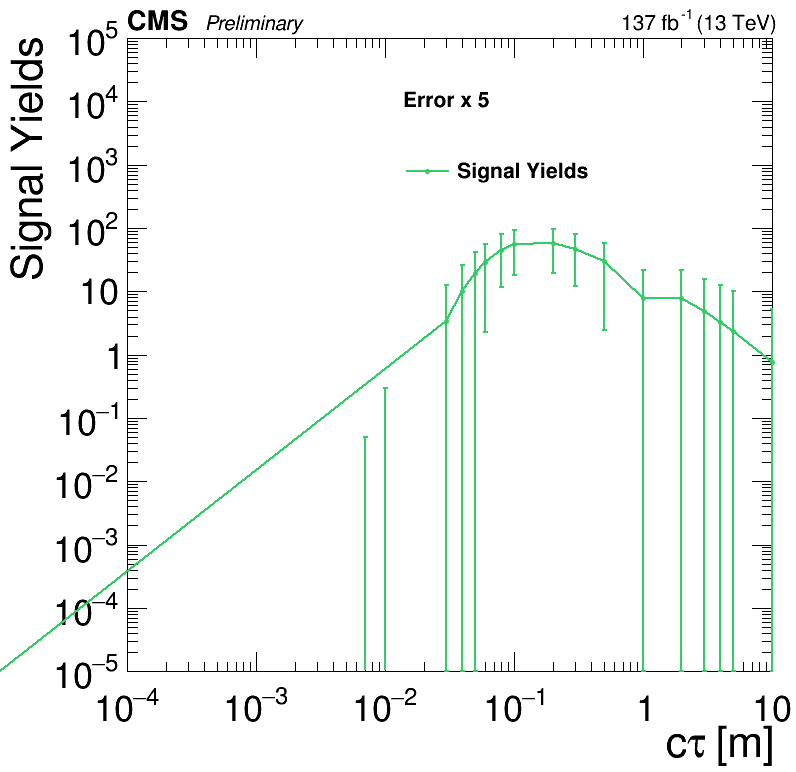

In [44]:
# plot 
ctaus_m = CTAUs/1000
for mass in masses:
    
    rt.gStyle.SetOptFit(1011)    

    c = rt.TCanvas('c','c', 800, 800)
    leg = rt.TLegend(0.5,0.73,0.80,0.92)
    leg.SetTextSize(0.03)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)

    h_sig = rt.TGraphErrors(npts, ctaus_m, sig_bin2_sum_arr[mass], ctaus_err, sig_bin2_sum_err_arr[mass]*5)


    h_sig.SetTitle(" ; c#tau [m];Signal Yields");
    leg.AddEntry(h_sig, "Signal Yields", "PL")
    leg.SetHeader( "Error x 5")
    h_sig.SetLineColor(845)
    h_sig.SetLineWidth(2)
    h_sig.SetMarkerColor(845)
    h_sig.SetMarkerStyle(20)
    h_sig.SetMarkerSize(0.5)
    h_sig.GetXaxis().SetLimits(0.0001,10.0)
    h_sig.GetYaxis().SetRangeUser(1e-5,1e+5)
    h_sig.GetXaxis().SetTitleOffset(1)

    h_sig.Draw('ALPsame')

    tdrstyle.setTDRStyle()
    CMS_lumi.cmsText     = "CMS"
    iPos = 0
    CMS_lumi.writeExtraText = True
    CMS_lumi.extraText   = "Preliminary"

    iPos = 0
    if( iPos==0 ): CMS_lumi.relPosX = 0.12
    CMS_lumi.CMS_lumi(c, 4, 0)
    leg.Draw()
    c.SetRightMargin(0.03)
    c.SetLogy()
    c.SetLogx()

    c.Draw()
    outDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200814/SignalYields/v0/'

    os.system("mkdir -p "+ outDir)
    c.SaveAs(outDir+'SignalYield_m'+mass+'.png')

In [48]:
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200804/DataCards/v0/'

# os.system("mkdir -p "+ plotDir)
for mass in masses:
    for ct in CTAUs:
        card_name = 'ggH_LLP_m'+mass+'_ctau'+str(ct)+'.txt'
        if sig_bin2_sum[mass][str(ct)] !=0:
            sig_unc = sig_bin2_sum_err[mass][str(ct)] / sig_bin2_sum[mass][str(ct)]
#             print(sig_unc)
        else:
            sig_unc = 0.2
        sig_stat = 0.2
        bkg_unc = data_bin2_sum_err / data_bin2_sum
        bkg_pred = 0.5
        sig_yield = sig_bin2_sum[mass][str(ct)]
        bkg_yield = data_bin2_sum
        make_datacard(plotDir, card_name, sig_yield, bkg_yield, sig_unc, sig_stat, bkg_unc, bkg_pred)
        print(plotDir+card_name)

/storage/user/jmao/gpu/jmao/cms-llp/plots/20200814/DataCards/v0/ggH_LLP_m15_ctau1.txt
/storage/user/jmao/gpu/jmao/cms-llp/plots/20200814/DataCards/v0/ggH_LLP_m15_ctau3.txt
/storage/user/jmao/gpu/jmao/cms-llp/plots/20200814/DataCards/v0/ggH_LLP_m15_ctau5.txt
/storage/user/jmao/gpu/jmao/cms-llp/plots/20200814/DataCards/v0/ggH_LLP_m15_ctau7.txt
/storage/user/jmao/gpu/jmao/cms-llp/plots/20200814/DataCards/v0/ggH_LLP_m15_ctau10.txt
/storage/user/jmao/gpu/jmao/cms-llp/plots/20200814/DataCards/v0/ggH_LLP_m15_ctau30.txt
/storage/user/jmao/gpu/jmao/cms-llp/plots/20200814/DataCards/v0/ggH_LLP_m15_ctau40.txt
/storage/user/jmao/gpu/jmao/cms-llp/plots/20200814/DataCards/v0/ggH_LLP_m15_ctau50.txt
/storage/user/jmao/gpu/jmao/cms-llp/plots/20200814/DataCards/v0/ggH_LLP_m15_ctau60.txt
/storage/user/jmao/gpu/jmao/cms-llp/plots/20200814/DataCards/v0/ggH_LLP_m15_ctau80.txt
/storage/user/jmao/gpu/jmao/cms-llp/plots/20200814/DataCards/v0/ggH_LLP_m15_ctau100.txt
/storage/user/jmao/gpu/jmao/cms-llp/plots/2020

In [52]:
for mass in masses:
    for ct in CTAUs:
        if ct>10:
            card_name = 'ggH_LLP_m'+mass+'_ctau'+str(ct)+'.txt'
        #     print(plotDir+card_name)
            print('combine -M AsymptoticLimits '+plotDir+card_name+' -n _ggH_LLP_m'+mass+'_ctau'+str(ct)+'  --rMin 0.0 --rMax 1.0 -t -1 --expectSignal 0 -m 125 > limit_ggH_LLP_m'+mass+'_ctau'+str(ct)+'.txt' )


combine -M AsymptoticLimits /storage/user/jmao/gpu/jmao/cms-llp/plots/20200814/DataCards/v0/ggH_LLP_m15_ctau30.txt -n _ggH_LLP_m15_ctau30  --rMin 0.0 --rMax 1.0 -t -1 --expectSignal 0 -m 125 > limit_ggH_LLP_m15_ctau30.txt
combine -M AsymptoticLimits /storage/user/jmao/gpu/jmao/cms-llp/plots/20200814/DataCards/v0/ggH_LLP_m15_ctau40.txt -n _ggH_LLP_m15_ctau40  --rMin 0.0 --rMax 1.0 -t -1 --expectSignal 0 -m 125 > limit_ggH_LLP_m15_ctau40.txt
combine -M AsymptoticLimits /storage/user/jmao/gpu/jmao/cms-llp/plots/20200814/DataCards/v0/ggH_LLP_m15_ctau50.txt -n _ggH_LLP_m15_ctau50  --rMin 0.0 --rMax 1.0 -t -1 --expectSignal 0 -m 125 > limit_ggH_LLP_m15_ctau50.txt
combine -M AsymptoticLimits /storage/user/jmao/gpu/jmao/cms-llp/plots/20200814/DataCards/v0/ggH_LLP_m15_ctau60.txt -n _ggH_LLP_m15_ctau60  --rMin 0.0 --rMax 1.0 -t -1 --expectSignal 0 -m 125 > limit_ggH_LLP_m15_ctau60.txt
combine -M AsymptoticLimits /storage/user/jmao/gpu/jmao/cms-llp/plots/20200814/DataCards/v0/ggH_LLP_m15_ctau80.t

# Limit plot

In [56]:
rtDir = '/storage/user/jmao/login-1/jmao/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/ggH_LLP_V1p17_v0/'
rtFiles = {}
rtTrees = {}
Limits = {}
LimitErrs = {}
for mass in masses:
    rtFiles[mass] = {}
    rtTrees[mass] = {}
    Limits[mass] = {}
    LimitErrs[mass] = {}
    for ct in CTAUs:
        if ct>10:
            rtName = 'higgsCombine_ggH_LLP_m'+mass+'_ctau'+str(ct)+'.AsymptoticLimits.mH125.root'
            print('ctau ', ct, ' mm')
        #     print(rtName)
            rtFiles[mass][str(ct)] = rtDir+rtName

            root_dir = uproot.open(rtFiles[mass][str(ct)])
            rtTrees[mass][str(ct)] = root_dir['limit']

            print( "-2\u03C3 , -\u03C3 , exp, +\u03C3 , +2\u03C3 , obs")
            v = rtTrees[mass][str(ct)]
            limit = v['limit'].array()
            print(limit)
            limitErr = v['limitErr'].array()
            print(limitErr)

            Limits[mass][str(ct)] = limit
            LimitErrs[mass][str(ct)] = limitErr


ctau  30  mm
-2σ , -σ , exp, +σ , +2σ , obs
[ 2.88554692  4.49296284  8.30000019 16.70337677 25.17240334  8.31160082]
[0.         0.         0.         0.         0.         0.02402122]
ctau  40  mm
-2σ , -σ , exp, +σ , +2σ , obs
[0.8480469  1.2547425  2.0875001  3.8515234  6.32828093 2.08266471]
[0.         0.         0.         0.         0.         0.00665056]
ctau  50  mm
-2σ , -σ , exp, +σ , +2σ , obs
[0.46862796 0.67758012 1.09062505 1.91660786 3.30549526 1.0899721 ]
[0.         0.         0.         0.         0.         0.00285919]
ctau  60  mm
-2σ , -σ , exp, +σ , +2σ , obs
[0.33906248 0.48551023 0.77499998 1.3310529  2.31659889 0.77343027]
[0.         0.         0.         0.         0.         0.00189683]
ctau  80  mm
-2σ , -σ , exp, +σ , +2σ , obs
[0.25744629 0.3676796  0.578125   0.979096   1.67280173 0.57830296]
[0.         0.         0.         0.         0.         0.00173739]
ctau  100  mm
-2σ , -σ , exp, +σ , +2σ , obs
[0.24144287 0.34482384 0.54218751 0.91823328 1.55

In [80]:
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot

start_t = time.time()
# CTAUs=np.array([1,3,5,7, 10, 30, 40, 50, 60, 80, 100, 200, 300, 500, 1000, 2000, 3000, 4000, 5000, 10000])
CTAUs=np.array([  30, 40, 50, 60, 80, 100, 200, 300, 500, 1000, 2000, 3000, 4000, 5000])

ctaus_m = CTAUs/1000
# npts = len(CTAUs)
npts = len(ctaus_m)
# print(npts)
# print(ctaus_m)
ctaus_2m = np.array(np.hstack((ctaus_m, np.flip(ctaus_m)))) 
# print(ctaus_2m)

# XSEC = 1e-03*1335.62*0.5824*0.5824 #pb
# print(XSEC)

expL = {}
exp1sigP = {}
exp1sigM = {}
exp2sigP = {}
exp2sigM = {}
exp1sig = {}
exp2sig = {}
for mass in masses:
    expL[mass] = []
    exp1sigP[mass] = []
    exp1sigM[mass] = []
    exp2sigP[mass] = []
    exp2sigM[mass] = []
    exp1sig[mass] = []
    exp2sig[mass] = []
    for ct in CTAUs:
        ctau = str(ct)
#         print(mass,ct)
#         print(Limits[mass][ctau])
#         print(Limits[mass][ctau][2])
        expL[mass].append(Limits[mass][ctau][2])
        exp1sigP[mass].append(Limits[mass][ctau][1])
        exp1sigM[mass].append(Limits[mass][ctau][3])
        exp2sigP[mass].append(Limits[mass][ctau][0])
        exp2sigM[mass].append(Limits[mass][ctau][4])
        
    expL[mass] = np.array(expL[mass])
    exp1sigP[mass]= np.array(exp1sigP[mass])
    exp1sigM[mass]= np.array(exp1sigM[mass])
    exp2sigP[mass]= np.array(exp2sigP[mass])
    exp2sigM[mass]= np.array(exp2sigM[mass])

    print(expL[mass])
    print(exp1sigP[mass])
    print(exp1sigM[mass])
    
    exp1sig[mass] = np.array(np.hstack((exp1sigP[mass], np.flip(exp1sigM[mass])))) 
    exp2sig[mass] = np.array(np.hstack((exp2sigP[mass], np.flip(exp2sigM[mass])))) 
    
# expL = np.array(expL)
# exp1sig= np.array(exp1sig)
# exp2sig= np.array(exp2sig)
# exp1sigP= np.array(exp1sigP)
# exp1sigM= np.array(exp1sigM)
# exp2sigP= np.array(exp2sigP)
# exp2sigM= np.array(exp2sigM)

print(expL)

[  8.30000019   2.0875001    1.09062505   0.77499998   0.578125
   0.54218751   0.77499998   1.15625      2.125       15.44999981
  26.79999924  73.75       156.1000061  200.        ]
[  4.49296284   1.2547425    0.67758012   0.48551023   0.3676796
   0.34482384   0.48551023   0.71535206   1.27235413   7.94141674
  13.10556602  32.27012634  62.75822449 117.14477539]
[ 16.70337677   3.8515234    1.91660786   1.3310529    0.979096
   0.91823328   1.3310529    2.04115152   3.93765306  31.09242821
  53.9337883  148.41854858 314.14422607 402.4909668 ]
[ 3.2750001   1.21562505  0.64687502  0.42031249  0.25156251  0.1921875
  0.15273437  0.18359375  0.28593749  1.49687505  2.2437501   5.125
  9.875      17.14999962]
[1.90985036 0.7520864  0.40974542 0.26946792 0.16299206 0.12500869
 0.09934632 0.11941886 0.18526424 0.91151869 1.34277165 2.90908813
 5.29129791 8.76760197]
[ 6.30359554  2.15565848  1.10584295  0.70512772  0.4140062   0.31322619
  0.24649045  0.29922014  0.47057846  2.70212984  

[  8.30000019   2.0875001    1.09062505   0.77499998   0.578125
   0.54218751   0.77499998   1.15625      2.125       15.44999981
  26.79999924  73.75       156.1000061  200.        ]
137 fb^{-1} (13 TeV)
377.80847120285034
[ 3.2750001   1.21562505  0.64687502  0.42031249  0.25156251  0.1921875
  0.15273437  0.18359375  0.28593749  1.49687505  2.2437501   5.125
  9.875      17.14999962]
137 fb^{-1} (13 TeV)
377.8762369155884
[2.0562501  0.59687501 0.29531249 0.19296876 0.12265625 0.10039063
 0.09609375 0.121875   0.190625   0.78437501 0.77812499 1.33749998
 2.0999999  3.11249995]
137 fb^{-1} (13 TeV)
377.9399540424347


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200814/LimitPlots/v0/Limit_m15.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200814/LimitPlots/v0/Limit_m40.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200814/LimitPlots/v0/Limit_m55.png has been created


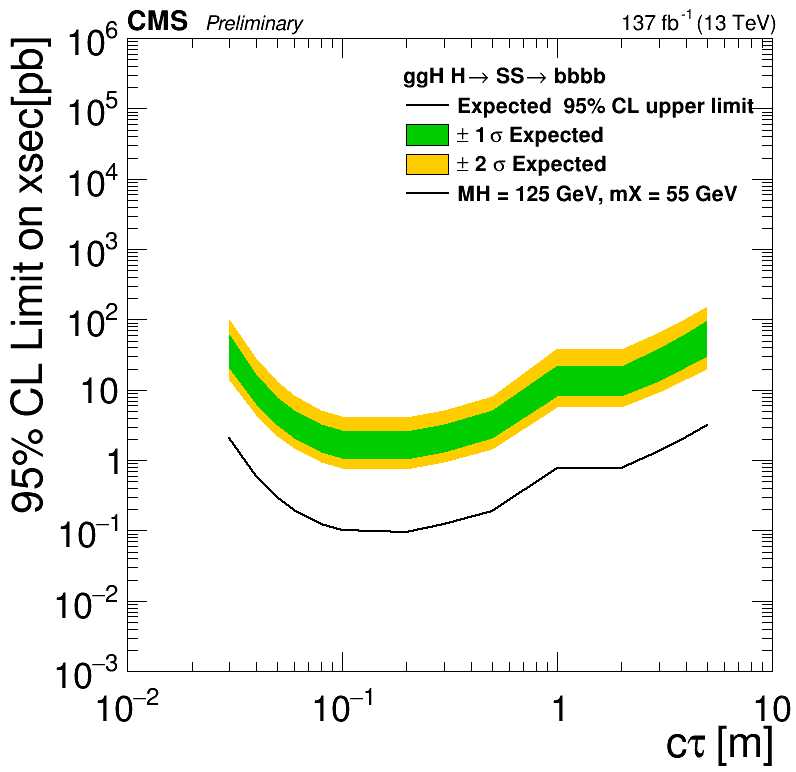

In [98]:
XSEC =  4.858E+01*0.5824*0.5824 #pb

for mass in masses:
    print(expL[mass])
    
    rt.gStyle.SetOptFit(1011)

    # h_exp = {}
    # h_exp1sig = {}
    # h_exp2sig = {}


    c = rt.TCanvas('c','c', 800, 800)
    leg = rt.TLegend(0.5,0.73,0.80,0.92)
    leg.SetTextSize(0.03)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)

    h_exp = create_TGraph(ctaus_m, expL[mass],  axis_title=['c#tau [m]', '95% CL Limit on xsec[pb]'])

    h_exp1sig = create_TGraph(ctaus_2m,  exp1sig[mass]*XSEC)
    h_exp2sig = create_TGraph(ctaus_2m,  exp2sig[mass]*XSEC)


    leg.AddEntry(h_exp, "Expected  95% CL upper limit", "L")
    leg.AddEntry(h_exp1sig, "#pm 1 #sigma Expected", 'F')
    leg.AddEntry(h_exp2sig, "#pm 2 #sigma Expected", 'F')
    leg.SetHeader('ggH H#rightarrow SS#rightarrow bbbb')
    leg.AddEntry(h_exp, "MH = 125 GeV, mX = "+mass+" GeV")
    h_exp.SetLineColor(1)
    h_exp.SetLineWidth(2)
    h_exp1sig.SetFillColor(417)
    h_exp2sig.SetFillColor(800)
    h_exp.GetXaxis().SetLimits(0.01,10.0)
    h_exp.GetYaxis().SetRangeUser(1e-3,1e+6)
    h_exp.GetXaxis().SetTitleOffset(1)

    h_exp.Draw('LA')
    h_exp2sig.Draw( 'Fsame')
    h_exp1sig.Draw('Fsame')
    h_exp.Draw('Lsame')

    tdrstyle.setTDRStyle()
    CMS_lumi.cmsText     = "CMS"
    iPos = 0
    CMS_lumi.writeExtraText = True
    CMS_lumi.extraText   = "Preliminary"

    iPos = 0
    if( iPos==0 ): CMS_lumi.relPosX = 0.12
    CMS_lumi.CMS_lumi(c, 4, 0)
    leg.Draw()
    c.SetRightMargin(0.03)
    c.SetLogy()
    c.SetLogx()

    c.Draw()
    print(time.time()-start_t) 
    LimDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200814/LimitPlots/v0/'

    os.system("mkdir -p "+ LimDir)
    c.SaveAs('/storage/user/jmao/gpu/jmao/cms-llp/plots/20200814/LimitPlots/v0/'+'Limit_m'+mass+'.png')